In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python.keras.layers import Add, Concatenate, Conv2D, Input, Lambda
from tensorflow.python.keras.models import Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.python.util import nest

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow_addons.callbacks import TQDMProgressBar

%run ../gridsearch/xception.ipynb

In [2]:
# A separate dataset for training a denoising network with fixed PSF and fixed noise
# Starting random seed for data generation 2314662
basedir = Path("../../")
dataset = basedir / "./data/data_v1a.npz"
modelpath = "./models/rdn_log.tf"

with np.load(dataset) as data:
    print("Available variables:", data.files)
    noisy = data["img"]
    noiseless = data["img_nonoise"]

Available variables: ['img', 'img_nonoise', 'label', 'psf_r', 'snr', 'sigma']


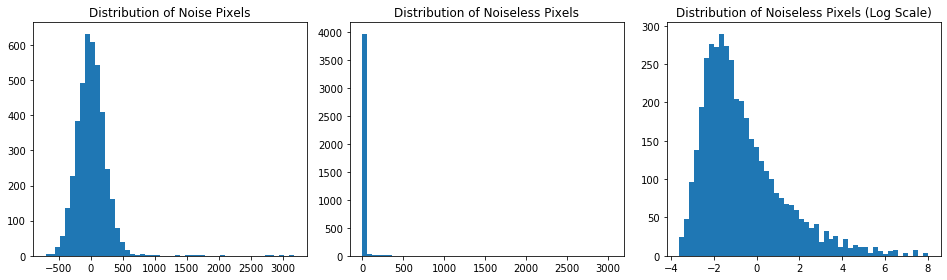

In [3]:
image_idx = 2

fig, ax = plt.subplots(1, 3, figsize=(13.5, 4), tight_layout=True)
ax[0].hist(noisy[image_idx].ravel(), bins=50)
ax[0].set_title("Distribution of Noise Pixels")
ax[1].hist(noiseless[image_idx].ravel(), bins=50)
ax[1].set_title("Distribution of Noiseless Pixels")
ax[2].hist(np.log(noiseless[image_idx]).ravel(), bins=50)
ax[2].set_title("Distribution of Noiseless Pixels (Log Scale)");

In [4]:
subset = 20_000
X = noisy[:subset, ..., np.newaxis]
Y = np.log(noiseless[:subset, ..., np.newaxis] + 1)

input_shape = X.shape[1:]

In [5]:
def RDB_conv(x, G=32):
    out = Conv2D(filters=G, kernel_size=3, padding="same", strides=1, activation="relu")(x)
    out = Concatenate()([x, out])
    return out


def RDB(x, C=6, G=32):
    inputs = x
    for _ in range(C):
        x = RDB_conv(x, G=G)
        
    # Local Feature Fusion
    x = Conv2D(filters=64, kernel_size=1, padding="same", strides=1)(x)  # alt: padding="valid"
    
    out = Add()([x, inputs])
    return out
        

def RDN(input_shape, D=20, C=6, G=32):
    """Build a Residual Dense Network.
    
    Args:
        input_shape: a 3-dimensional tuple of the input shape (including the channel dimension)
        D: the number of residual dense blocks
        C: the number of convolutional layers in each residual dense block
        D: growth rate of residual dense blocks
    """    
    inputs = Input(shape=input_shape)
    x = preprocessing.Normalization()(inputs)
    
    # Shallow feature extraction
    sfe1 = Conv2D(filters=64, kernel_size=3, strides=1, padding="same")(x)
    sfe2 = Conv2D(filters=64, kernel_size=3, strides=1, padding="same")(sfe1)
    x = sfe2
    
    RDBs = []
    for _ in range(D):
        x = RDB(x, C=C, G=G)
        RDBs.append(x)
        
    x = Concatenate()(RDBs)
    
    # Global Feature Fusion
    gff1 = Conv2D(filters=64, kernel_size=1, strides=1, padding="same")(x)  # alt: padding="valid"
    gff2 = Conv2D(filters=64, kernel_size=3, strides=1, padding="same")(gff1)
    
    x = Add()([gff2, sfe1])
    outputs = Conv2D(filters=input_shape[-1], kernel_size=3, strides=1, padding="same")(x)

    model = Model(inputs, outputs, name="RDN")
    return model

In [10]:
model = RDN(input_shape, D=3)
adapt_model(model, X);
# model.summary()

In [11]:
# Setup callbacks. TQDM is used due to issues with the default progress bar on my TF2.1 installation.
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
tqdm_callback = TQDMProgressBar()
checkpoint = ModelCheckpoint(modelpath, save_best_only=True)

model.compile(optimizer=Adam(0.0001), loss="mae")
history = model.fit(
    X,
    Y,
    batch_size=32,
    epochs=100,
    validation_split=0.2,
    verbose=0,
    callbacks=[early_stopping, tqdm_callback, checkpoint],
)
model.save(modelpath)

Epoch 1/100



Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: rdn_log.tf/assets
Epoch 2/100



INFO:tensorflow:Assets written to: rdn_log.tf/assets
Epoch 3/100



INFO:tensorflow:Assets written to: rdn_log.tf/assets
Epoch 4/100



Epoch 5/100



INFO:tensorflow:Assets written to: rdn_log.tf/assets
Epoch 6/100



Epoch 7/100



INFO:tensorflow:Assets written to: rdn_log.tf/assets
Epoch 8/100



INFO:tensorflow:Assets written to: rdn_log.tf/assets
Epoch 9/100



INFO:tensorflow:Assets written to: rdn_log.tf/assets
Epoch 10/100



Epoch 11/100



INFO:tensorflow:Assets written to: rdn_log.tf/assets
Epoch 12/100



Epoch 13/100



Epoch 14/100



INFO:tensorflow:Assets written to: rdn_log.tf/assets
Epoch 15/100



INFO:tensorflow:Assets written to: rdn_log.tf/assets
Epoch 16/100



INFO:tensorflow:Assets written to: rdn_log.tf/assets
Epoch 17/100



INFO:tensorflow:Assets written to: rdn_log.tf/assets
Epoch 18/100



INFO:tensorflow:Assets written to: rdn_log.tf/assets
Epoch 19/100



Epoch 20/100



Epoch 21/100



INFO:tensorflow:Assets written to: rdn_log.tf/assets
Epoch 22/100



INFO:tensorflow:Assets written to: rdn_log.tf/assets
Epoch 23/100



INFO:tensorflow:Assets written to: rdn_log.tf/assets
Epoch 24/100



INFO:tensorflow:Assets written to: rdn_log.tf/assets
Epoch 25/100



Epoch 26/100



INFO:tensorflow:Assets written to: rdn_log.tf/assets
Epoch 27/100



INFO:tensorflow:Assets written to: rdn_log.tf/assets
Epoch 28/100



INFO:tensorflow:Assets written to: rdn_log.tf/assets
Epoch 29/100



Epoch 30/100



Epoch 31/100



Epoch 32/100



INFO:tensorflow:Assets written to: rdn_log.tf/assets
Epoch 33/100



Epoch 34/100



Epoch 35/100



INFO:tensorflow:Assets written to: rdn_log.tf/assets
Epoch 36/100



Epoch 37/100



Epoch 38/100



Epoch 39/100



Epoch 40/100



INFO:tensorflow:Assets written to: rdn_log.tf/assets
Epoch 41/100



INFO:tensorflow:Assets written to: rdn_log.tf/assets
Epoch 42/100



Epoch 43/100



Epoch 44/100



Epoch 45/100



Epoch 46/100



Epoch 47/100



Epoch 48/100



INFO:tensorflow:Assets written to: rdn_log.tf/assets
Epoch 49/100



Epoch 50/100



Epoch 51/100



INFO:tensorflow:Assets written to: rdn_log.tf/assets
Epoch 52/100



INFO:tensorflow:Assets written to: rdn_log.tf/assets
Epoch 53/100



Epoch 54/100



INFO:tensorflow:Assets written to: rdn_log.tf/assets
Epoch 55/100



INFO:tensorflow:Assets written to: rdn_log.tf/assets
Epoch 56/100



Epoch 57/100



INFO:tensorflow:Assets written to: rdn_log.tf/assets
Epoch 58/100



Epoch 59/100



Epoch 60/100



Epoch 61/100



Epoch 62/100



Epoch 63/100



INFO:tensorflow:Assets written to: rdn_log.tf/assets
Epoch 64/100



INFO:tensorflow:Assets written to: rdn_log.tf/assets
Epoch 65/100



Epoch 66/100



Epoch 67/100



INFO:tensorflow:Assets written to: rdn_log.tf/assets
Epoch 68/100



Epoch 69/100



Epoch 70/100



Epoch 71/100



INFO:tensorflow:Assets written to: rdn_log.tf/assets
Epoch 72/100



Epoch 73/100



INFO:tensorflow:Assets written to: rdn_log.tf/assets
Epoch 74/100



INFO:tensorflow:Assets written to: rdn_log.tf/assets
Epoch 75/100



Epoch 76/100



INFO:tensorflow:Assets written to: rdn_log.tf/assets
Epoch 77/100



INFO:tensorflow:Assets written to: rdn_log.tf/assets
Epoch 78/100


KeyboardInterrupt: 

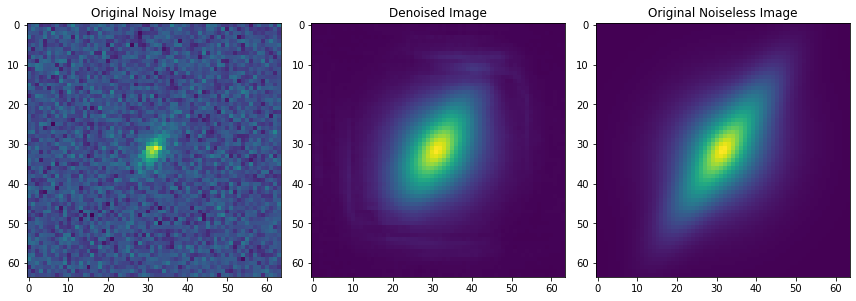

In [14]:
# Plot the results
pred = model.predict(X[np.newaxis, 0])[0]

fig, ax = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)
ax[0].imshow(X[0].reshape(64, 64))
ax[0].set_title("Original Noisy Image")
ax[1].imshow(pred.reshape(64, 64))
ax[1].set_title("Denoised Image")
ax[2].imshow(Y[0].reshape(64, 64))
ax[2].set_title("Original Noiseless Image");

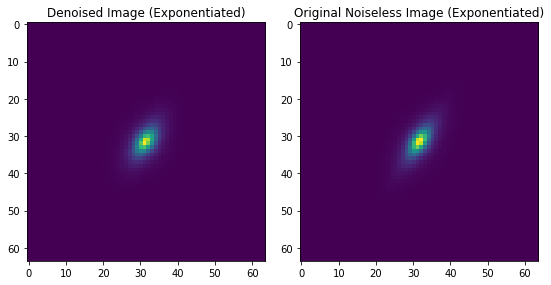

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), tight_layout=True)
ax[0].imshow(np.exp(pred).reshape(64, 64) - 1)
ax[0].set_title("Denoised Image (Exponentiated)")
ax[1].imshow(np.exp(Y[0]).reshape(64, 64) - 1)
ax[1].set_title("Original Noiseless Image (Exponentiated)");

In [ ]:
# lr=0.0001 
# adam = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=lr / 2, amsgrad=False)

#     ## multi gpu setting

#     # if gpu < 0:
#     # model = multi_gpu_model(model, gpus=2)
#     ## Modification of adding PSNR as a loss factor
#     model.compile(loss=self.L1_loss, optimizer=adam, metrics=[PSNRLoss, SSIM])